## Flux-based hierarchical organization of _Escherichia coli_'s metabolic network
This notebook contains the workflow used to generate the results presented in accompanying paper: Robaina-Estévez and Nikoloski (2019). Specifically, we will find and analyze the flux-ordered reaction pairs found in _E. coli_'s genome-scale metabolic model iJO1366 [REF] under growth in three carbon sources: glucose, glycerate and acetate. Further, we reconstruct the directed acyclic graph (DAG) which represents the flux-order relation and anaylze which metabolic subsystems are enriched in each graph level. Finally, we evaluate whether or not diverse experimental measurements&mdash;such as ${}^{13}\mathrm{C}$-estimated fluxes, protein and transcript levels&mdash;reflect the predicted flux-order relation. Let's get started!

In [3]:
# Import required libraries 
from DataClasses import *
from ModelClasses import *
from OrderClasses import *
import OrderClasses
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_venn import venn3_unweighted
plt.style.use('seaborn')
from ipywidgets import widgets, interact
from scipy.spatial import distance
from scipy.cluster import hierarchy
carbonSources = ['glucose', 'acetate', 'glycerate']
workDir = 'C:/Users/tinta/OneDrive/Documents/Projects/Ordering_of_Fluxes'
%matplotlib inline

### Creating model instancies for the three carbon sources
We begin by importing the iJO1366 model into the cobrapy toolbox, we will process the model to remove blocked reactions (REF) and to split reversible reactions into the two possible directions: forward and backward (here tagged as reverse). The class Model provides all the required methods. Relevant code can be found in the module _ModelClasses_. In all three cases, we simulate the growth of _E. coli_ in a minimal medium with a single carbon source, to this end, we neglect the import of any organic compound besides the carbon source and cobalamine (vitamin B12), since _E. coli_ cannot produce it on its own. We set the maximum carbon source uptake flux to be 20 $mmol.L^{-1}.min^{-1}$, and constraint the flux through the biomass reaction to be at least 95% of the maximum flux possible under the given constraints.

In [4]:
# Prepare Models for the three carbon sources
iJO1366 = {}
for carbonSource in carbonSources + ['all']:
    iJO1366[carbonSource] = Model(fileName='iJO1366.json', workDir=workDir + '/Data/Models/iJO1366')
    if carbonSource is not 'all':
        iJO1366[carbonSource].updateExchangeReactionBounds(
            carbonSource=carbonSource, carbonUptakeRate=20)
    iJO1366[carbonSource].setMinimumProduction(fractionOfOptimum=0.95)

Split GEM generated with 2100 non-blocked reactions and 1155 metabolites
Maximum growth rate under glucose: 1.986149098710268 h^{-1}
Split GEM generated with 2100 non-blocked reactions and 1155 metabolites
Maximum growth rate under acetate: 0.5084981153029648 h^{-1}
Split GEM generated with 2100 non-blocked reactions and 1155 metabolites
Maximum growth rate under glycerate: 0.7538896467042152 h^{-1}
Split GEM generated with 2100 non-blocked reactions and 1155 metabolites
Maximum growth rate under all: 20.748004213609146 h^{-1}


## Finding flux-ordered reaction pairs
Now that we have prepared the iJO1366 model, we proceed to find all flux-ordered reaction pairs for the three carbon sources. That is, for each reaction pair $r_i,r_j$ in the model we want to test whether their fluxes satisfy $v_i \geq v_j, \forall v \in C = \{v:Sv=0,v_{min} \leq v \leq v_{max}\}$ (see [ref] for details). To this end, we employ a simple linear program which maximizes the flux ratio of a pair of reactions. Specifically, we start with the linear-fractional program

\begin{align}
\begin{aligned}
&z_{max} = \max_v \; \frac{v_j}{v_i}
\\
&\mathrm{s.t.}
\\
&Sv=0
\\
&v_{min} \leq v \leq v_{max}
\end{aligned}
\label{eq:1}
\end{align}

and apply the Charnes-Cooper transformation [REF] to obtain the linear program

\begin{align}
\begin{aligned}
&z_{max} = \max_{w,t} \; w_j
\\
&\mathrm{s.t.}
\\
&Sw = 0
\\
&w_i = 1
\\
&tv_{min} \leq w \leq tv_{max}
\\
&t \geq 0
\end{aligned}
\label{eq:2}
\end{align}

in which $w_j = \frac{v_j}{v_i}$. A reaction pair is then flux-ordered if $z_{max} \leq 1$. However, repeating this process for all possible reaction pairs in the model is computationally intensive, since the number of pairs grows as $0.5 n(n-1)$ where $n$ is the number of reactions in the model. To speed up the computational time, we first apply a less computationally expensive process in which we discard reaction pairs that cannot be flux-ordered. Specifically, we draw a number of random flux samples for all reactions in the model, then we discard reaction pairs for which in at least one of the samples the flux order relation is not satisfied. We call the remaining reaction pairs _candidate flux-ordered_, which we further test with the previous linear program to assertain whether or not they really are flux-ordered.

As an example, let's find the candidate flux-ordered pairs in the case of growth in minimal medium with glucose as the sole carbon source.

In [6]:
# Find candidate flux-ordered reaction pairs
iJO1366['glucose'].findCandidatePairs(nsamples=5000)

Finding candidate ordered reaction pairs
There are: 492959 candidate pairs out of 2203950.0 total pairs


Unline flux coupling relations, the flux order relation depends on the flux bounds of each reactions. For instance, in the following interactive figure, we have allowed steady-state flux space for two reactions $r_i, r_j$, which is delimited by the two constraints depicted in red and blue. Every flux pair above the dashed line representing $v_i = v_j$ satisfies $v_i > v_j$. Now, the adjustable golden line depicts the flux upper bound of reaction $v_j$. We see that only when the upper bound reaches a value of 400 the reaction pair becomes flux-ordered, since the feasible region, shaded in grey, lays entirely above the dashed line. The dependency of the flux-order relation of the flux bounds is also the reason why different sets of flux-ordered pairs may be found under different simulated conditions, such as the three carbon sources evaluated here. 

In [2]:
interact(plot_example, fluxUpperBound = widgets.FloatSlider(value=750, min=0,  max=1000, step=50,
                                                         description='$v_j^{ub}$', readout=True))
plt.show()

interactive(children=(FloatSlider(value=750.0, description='$v_j^{ub}$', max=1000.0, step=50.0), Output()), _d…

Now that we have found the candidate flux-ordered pairs, we are ready to evaluate which of the candidates are truly ordered. Solving the previously presented linear program for each of the candidate pairs is an <a href="https://en.wikipedia.org/wiki/Embarrassingly_parallel">embarrassingly parallel</a> task, hence, we employ the Gurobi solver [REF] in a parallel setting using the R programming language. To this end, we can call the R function _get_flux_orders_ through python using the _rpy2_ module

```Python
fluxOrders_A = get_flux_orders(S, lb, ub, candidatePairs)

```
which returns the adjacency matrix of the directed acyclic graph representing the flux order relation, that is, the entry $a_{ij} = 1$ if $v_i \geq v_j$ and $a_{ij} = 0$ otherwise.

Finding all flux-ordered pairs took around 5 hours using a laptop with 4 cores and a maximum CPU seep of 2.3 Mhz for each carboun source. To accelerate this process, we will upload the already computed adjacecy matrices for each of the three carbon sources.

In [5]:
# Upload adjacency matrices for each carbon source
iJO1366_A = {}
for carbonSource in carbonSources:
    iJO1366_A[carbonSource] = np.asarray(
        np.genfromtxt(workDir + '/Data/Models/iJO1366/iJO1366_AdjMat_' 
                      + carbonSource + '.csv', delimiter=','))

For an interactive version of the Hasse diagram depicting the flux order relation of _E. coli_'s core metabolic network under growth on glucose click on the following image:

<a href="https://robaina.github.io/fluxOrders/" target="_blank"><img style="margin:0px auto;display:block" src="Hasse.png" alt="Responsive image" width=450></a>

## Comparing the flux-ordered pairs among the three carbon sources
Here, we analyze the similarities and differencies between the flux order graphs of the three carbon sources. First of all, we generate a Venn diagram to show the extent to which flux-ordered reaction pairs are shared among carbon sources. We will also compute the Jaccard distance between each Hasse diagram and plot a dendrogram summarizing the results.

In [4]:
# Extract the set of ordered pairs for each carbon source
ordered_pairs, number_pairs = {}, {}
for carbonSource in carbonSources:
    ordered_pairs[carbonSource] = set(np.where(iJO1366_A[carbonSource].flatten() == 1)[0])
    number_pairs[carbonSource] = len(ordered_pairs[carbonSource])

# Reconstruct the Jaccard distance matrix   
iJO1366_D = pd.DataFrame(np.zeros((3, 3)), index=carbonSources, columns=carbonSources)
for carbonSource1 in carbonSources:
    for carbonSource2 in carbonSources:
        dist = distance.jaccard(iJO1366_A[carbonSource1].flatten(), iJO1366_A[carbonSource2].flatten())
        iJO1366_D[carbonSource1][carbonSource2] = dist

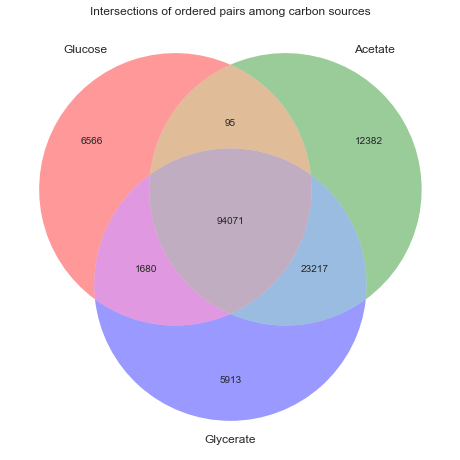

In [41]:
# Plot figure
plt.figure(figsize=(8, 8))
plt.title('Intersections of ordered pairs among carbon sources')
venn3_unweighted(ordered_pairs.values(), ordered_pairs.keys())
plt.show()

We can see in the Venn diagram that a large number of flux-ordered reaction pairs are shared among the three carbon sources. Additionally, the acetate and glycerate are the carbon sources that produce more similar sets of flux-ordered pairs, and acetate is the carbon source which contains the largest number of exclusice flux-ordered pairs.  

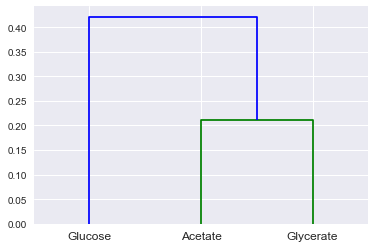

In [43]:
# Plot dendrogram of Jaccard distance
Z = hierarchy.linkage(1 - iJO1366_D.values, 'single')
hierarchy.dendrogram(Z, labels=iJO1366_D.columns)
plt.show()

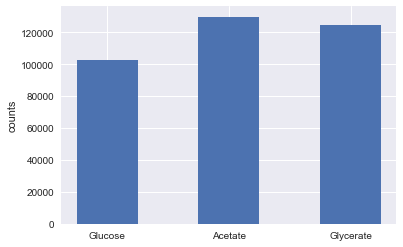

In [35]:
# Plot bar plot with total counts
plt.bar(range(3), number_pairs.values(), width=0.5, tick_label=list(number_pairs.keys()))
plt.ylabel('counts')
plt.show()

## Representation of metabolic systems in the Hasse diagram
Next, we will analyze which metabolic systems are represented in each level of the Hasse diagram corresponding to each carbon source. Let's start by extracting all the reactions in each of the levels of the flux order graph and per each carbon source.

Computing orders graph levels...
Computing orders graph levels...
Computing orders graph levels...


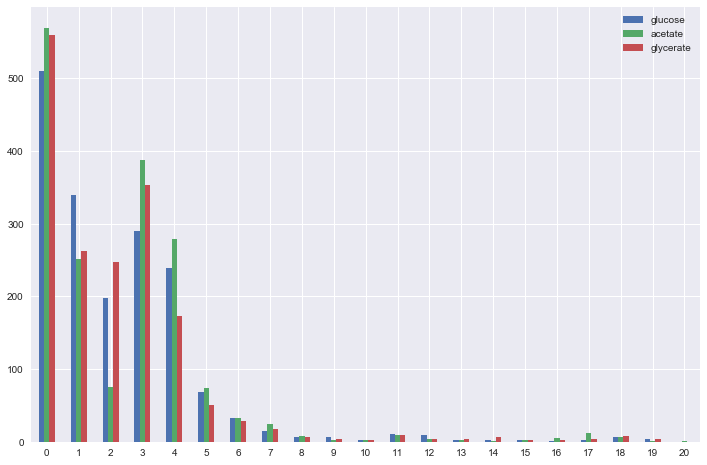

In [6]:
# Generate the graph of the Hasse diagram through networkx
iJO1366_fctable = np.genfromtxt(
    workDir + '/Data/Models/iJO1366/fc' + 'iJO1366' + '.csv', delimiter=',')
Graph_Levels = {}
for carbonSource in carbonSources:
    Graph_Levels[carbonSource] = iJO1366[carbonSource].getFluxOrders(
        iJO1366_A[carbonSource], iJO1366_fctable).getGraph().getGraphLevels()

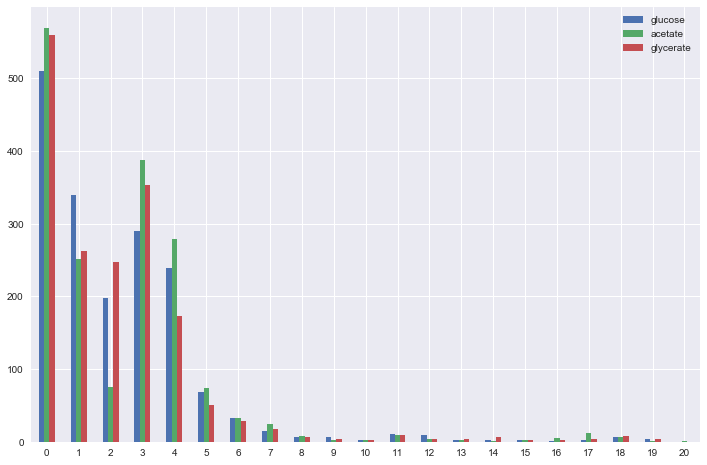

In [7]:
_ = plotNumberOfReactionsPerGraphLevel(Graph_Levels)

We can see that the first levels, _i.e._ those in which reactions tend to impose an upper flux bound to the larger number of reactions, accumulate the majority of reactions involved in a flux order relation. Additionally, we observe no large differences among carbon sources. Acetate produces a graph with an additional level. Let's now plot a stacked bar plot depicting the representation of each metabolic macrosystem in the entire set of ordered reaction pairs for each carbon source

In [9]:
# Get sets of shared and exclusive reactions in the flux-order graph among carbon sources
shared_reactions, exclusive_reactions = extractSharedAndExclusiveReactions(Graph_Levels)

# Get total reactions in the same structure as exclusive reactions
total_reactions = {}
max_number_of_levels = max([len(Graph_Levels[source]) for source in carbonSources])
for level in range(max_number_of_levels):
    total_reactions[level] = {}
    for carbonSource in carbonSources:
        try:
            reaction_list = Graph_Levels[carbonSource][level]
        except Exception:
            reaction_list = []
        
        total_reactions[level][carbonSource] = reaction_list

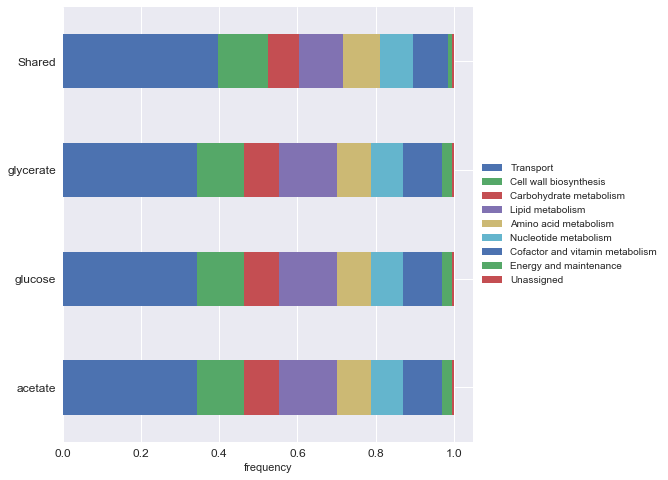

In [12]:
plotTotalSystemDistribution(iJO1366['all'].GEM, shared_reactions, total_reactions, systemType='macrosystem')

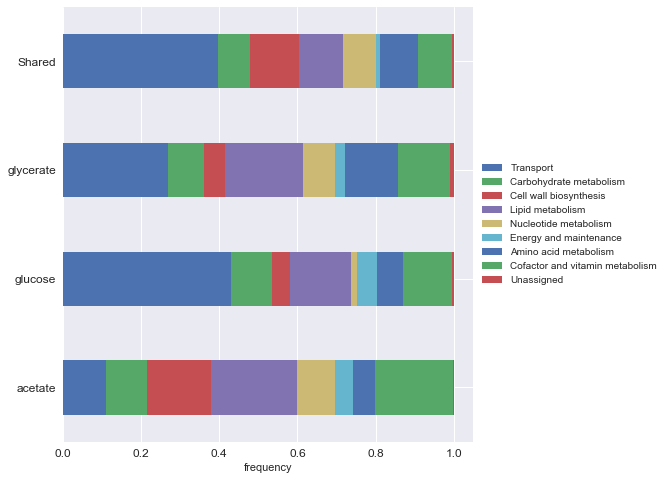

In [11]:
plotTotalSystemDistribution(iJO1366['all'].GEM, shared_reactions, exclusive_reactions, systemType='macrosystem')

We can see that _Transport_ is the most frequent macrosystem in all three cases, followed by carnohydrate metabolism. Let's increase the resolution and plot the frequencies of macrosystems per graph level and carbon source next

In [13]:
# Plot distribution of metabolic macrosystems per graph level
shared_system_distribution, exclusive_system_distribution, total_system_distribution = {}, {}, {}
for systemType in ['macrosystem', 'subsystem']:
    shared_system_distribution[systemType] = getSystemDistributionPerGraphLevel(
        iJO1366['all'].GEM, shared_reactions, systemType)
    exclusive_system_distribution[systemType] = getSystemDistributionPerGraphLevel(
        iJO1366['all'].GEM, exclusive_reactions, systemType)
    total_system_distribution[systemType] = getSystemDistributionPerGraphLevel(
        iJO1366['all'].GEM, total_reactions, systemType)

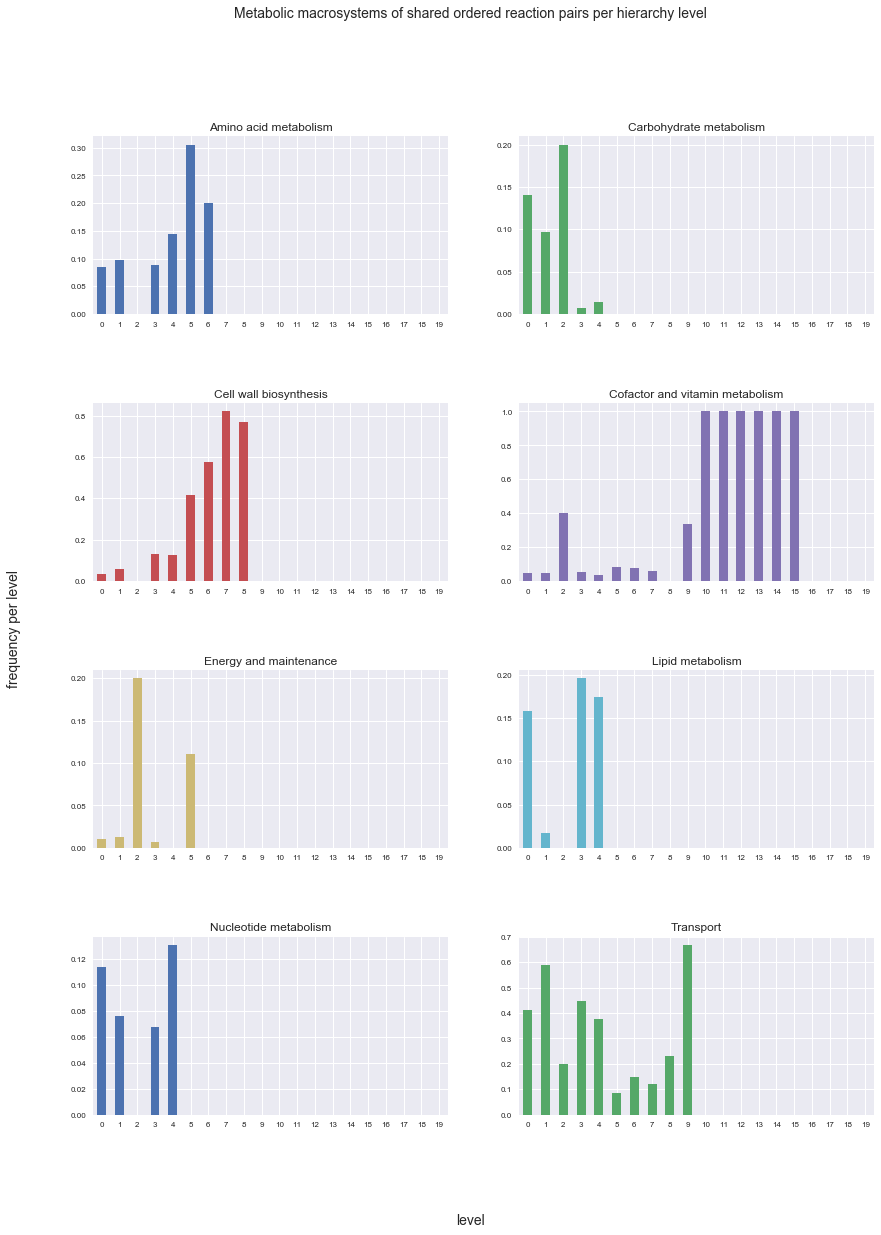

In [14]:
plotMacrosystemFrequencyPerGraphLevel(shared_system_distribution['macrosystem'])

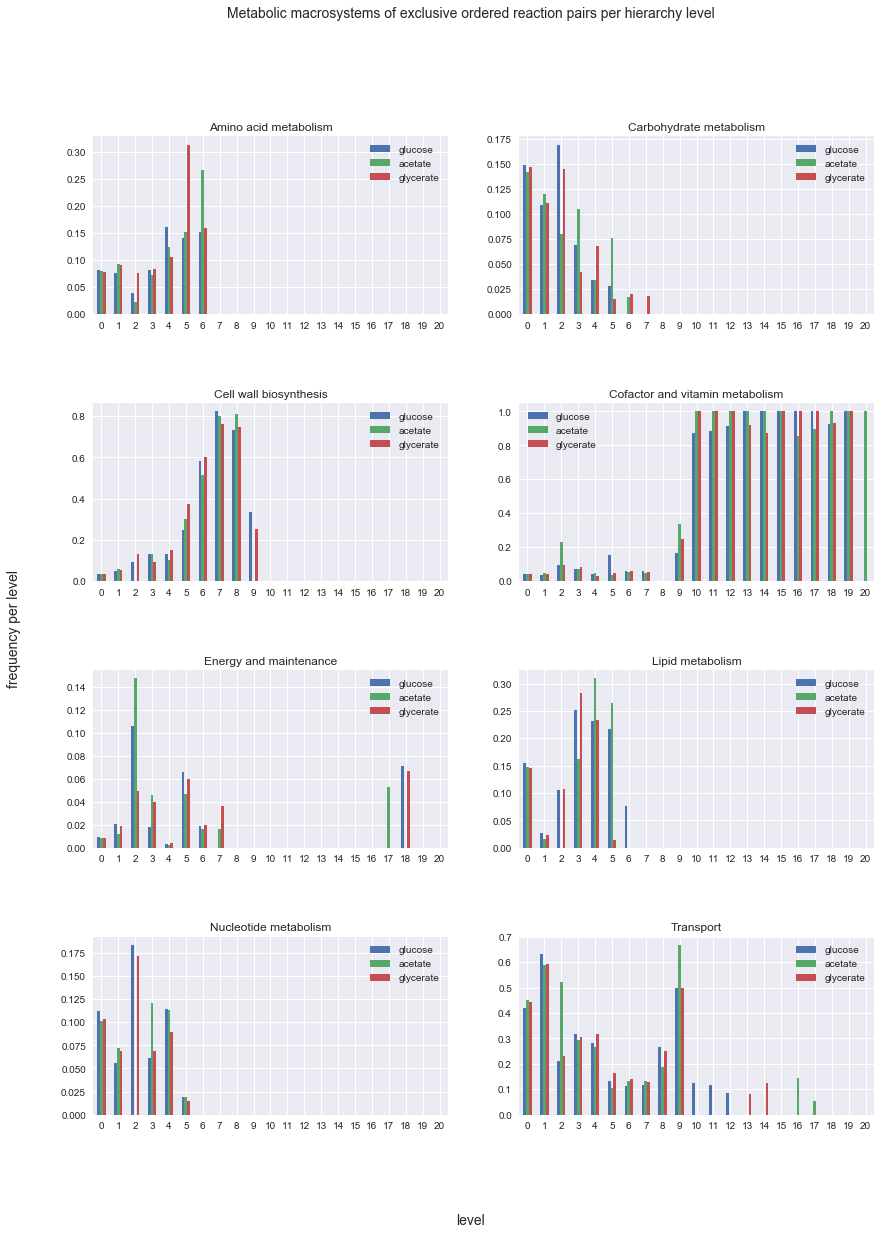

In [15]:
plotMacrosystemFrequencyPerGraphLevel(total_system_distribution['macrosystem'])

In [146]:
def plotLevelSubsystems(GEM, graph_reactions):
    """
    Computes the frequencies of the subsystems of the reactions appearing
    in the specified graph level which have the specified macrosystem
    """
    macrosystems = ['Amino acid metabolism', 'Carbohydrate metabolism', 'Cell wall biosynthesis',
                   'Cofactor and vitamin metabolism', 'Energy and maintenance', 'Lipid metabolism',
                   'Nucleotide metabolism', 'Transport']

    def plot_func(macrosystem, level_number, save_fig):
        def getListFrequencies(a_list):
            return {k: v / len(a_list) for k, v in Counter(a_list).items()}

        total_subsystems = {}
        level_reactions = graph_reactions[level_number]
        for source in level_reactions.keys():
            subsystems = []
            for multiple_rxn_id in level_reactions[source]:
                rxn_ids = re.split(r'\|\|', multiple_rxn_id)
                for rxn_id in rxn_ids:
                    if GEM.reactions.get_by_id(rxn_id).macrosystem in macrosystem:
                        subsystems.append(GEM.reactions.get_by_id(rxn_id).subsystem)
            total_subsystems[source] = getListFrequencies(subsystems)

        df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in total_subsystems.items()]))
        try:
            df.plot(kind='bar', rot=75, figsize=(10, 6), fontsize=12)
            plt.title(macrosystem + ', level ' + str(level_number), fontsize=14)
            plt.ylabel('frequency')
        except Exception:
            plt.figure(figsize=(10, 6))
            plt.title('No data available', fontsize=16)
        if save_fig:
            plt.savefig('figure.png', dpi=150)

    interact(plot_func, macrosystem=macrosystems,
             level_number=widgets.FloatSlider(
                 value=0, min=0,  max=20, step=1, description='graph level', readout=True),
             save_fig=False)
#     plt.show()
    
    
def plotSystemsPerGraphLevel(macrosystem_frequencies):
    """
    Plot barplot with the frequency of macrosystems per
    graph level for each carbon source
    """

    fig, axs = plt.subplots(nrows=4, ncols=2, sharex=False,
                            sharey=False, figsize=(14, 18))
    fig.text(0.5, 0.04, 'level', ha='center', fontsize=14)
    fig.text(0.04, 0.5, 'frequency per level', va='center', rotation='vertical', fontsize=14)
    fig.suptitle('Metabolic macrosystems of ' + data_type + ' ordered reaction pairs per hierarchy level',
                 fontsize=14)
    plt.subplots_adjust(wspace=None, hspace=0.5)


    
    i = 0
    for system in macrosystem_frequencies.keys():
        df = pd.DataFrame.from_dict(macrosystem_frequencies[system])
        if 'Unassigned' in df.columns:
            df.drop(['Unassigned'], axis=1)
        df.plot.bar(ax=axs[i // 2][i % 2], rot=0, title=system)
        i += 1

        # CONTINUE: would be cool to have the two plots: macrosystem and subsystems one after the other. The user controls
        # macrosystems in the first case, then in the second plot the graph level. 

In [148]:
plotLevelSubsystems(iJO1366['all'].GEM, total_reactions)

interactive(children=(Dropdown(description='macrosystem', options=('Amino acid metabolism', 'Carbohydrate meta…

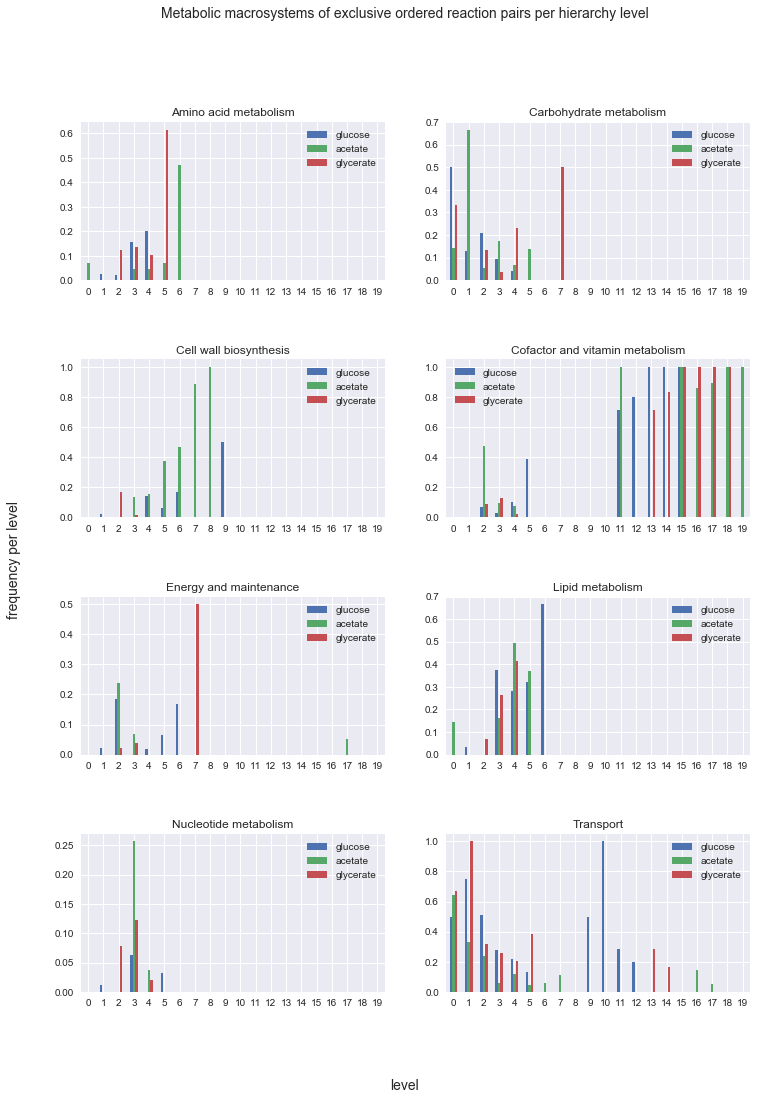

In [29]:
plotMacrosystemFrequencyPerGraphLevel(exclusive_system_distribution['macrosystem'])

We observed that macrosystems tend to preferentially distribute near the first levels or the last levels. For instance, _Transport_ remains in the first levels while _Cofactor and vitamin metabolism_ remains at the last levels. We can increase the resolution even more and explore what subsystems are involved in some of the macrosystems observed previously. For instance, let's look at the pick formed by _Carbohydrate metabolism_ in the third level under acetate as acarbon source

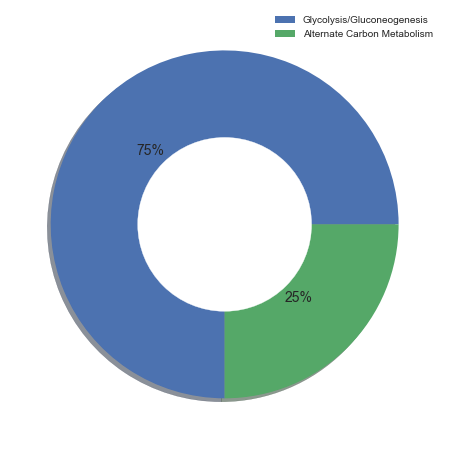

In [62]:
level = 0
carbonSource = 'glucose'
macrosystem = 'Carbohydrate metabolism'
_ = plotLevelSubsystems(iJO1366['all'].GEM,
                        exclusive_reactions[level][carbonSource], macrosystem)

We see that the macrosystem is formed by...

## Evaluating the flux order relation in experimental data
Next, we are going to test whether diverse data sets tend to follow the flux order relation previously described.

In [65]:
# Parse experimental data
iJO1366_Data = iJO1366['all'].parseData()
proteinCosts = iJO1366_Data.getProteinCosts()
transcriptValues = iJO1366_Data.getTranscriptValues()
proteinValues = iJO1366_Data.getProteinValues()
fluxValues = iJO1366_Data.getFluxValues()
kcatValues = iJO1366_Data.getKcatValues()
activityValues = iJO1366_Data.getActivityValues()
Gscores = iJO1366_Data.getGeneGscores()
GRN = iJO1366_Data.getGeneRegulatoryInteractions()

gene_data = [transcriptValues, proteinValues]
reaction_data = [fluxValues, activityValues, kcatValues]
data_colors = {'transcript':'#ffbf00', 'protein':'#a217ed',
               'flux':'#25a9f4', 'kcat':'#b50636', 'activity':'#0acd47'}
costThresholds = [0, 70, 80, 85]

Now that we have all experimental data at hand, let's evaluate to which extent data follows the flux order relation

In [66]:
%%capture
transcript_plots, protein_plots = {}, {}

for carbonSource in carbonSources:
    transcript_plots[carbonSource] = iJO1366[carbonSource].getFluxOrders(
        iJO1366_A[carbonSource], iJO1366_fctable).evaluateDataOrders(
        data=transcriptValues[carbonSource], proteinCosts=proteinCosts, plotStaticFigures=False,
        plotAnimatedFigures=True, costPercentileThresholds=costThresholds,
        color=data_colors['transcript'])
    
    protein_plots[carbonSource] = iJO1366[carbonSource].getFluxOrders(
        iJO1366_A[carbonSource], iJO1366_fctable).evaluateDataOrders(
        data=proteinValues[carbonSource], proteinCosts=proteinCosts, plotStaticFigures=False,
        plotAnimatedFigures=True, costPercentileThresholds=costThresholds,
        color=data_colors['protein'])

flux_plot_Glu = iJO1366['glucose'].getFluxOrders(
    iJO1366_A['glucose'], iJO1366_fctable).evaluateDataOrders(
    data=fluxValues, color=data_colors['flux'])[0]

kcat_plot_Glu = iJO1366['glucose'].getFluxOrders(
    iJO1366_A['glucose'], iJO1366_fctable).evaluateDataOrders(
    data=kcatValues, color=data_colors['kcat'])[0]

activity_plot_Glu = iJO1366['glucose'].getFluxOrders(
    iJO1366_A['glucose'], iJO1366_fctable).evaluateDataOrders(
    data=activityValues, color=data_colors['activity'])[0]

Let's look first at the reaction flux data set

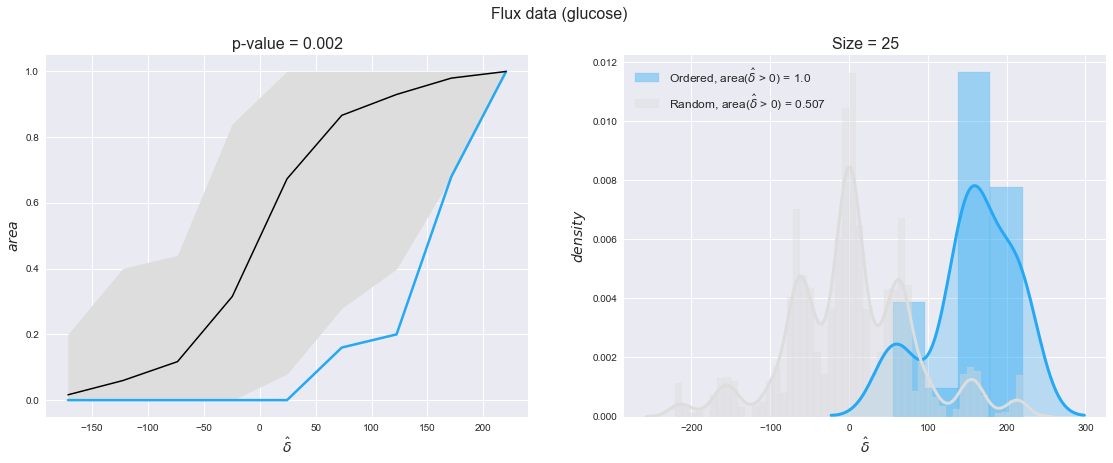

In [13]:
flux_plot_Glu

We see that the flux data satisfies the flux order relation in all cases, only 25 flux-ordered pairs with available data in this case. 

Estimating flux values from ${}^{13}\mathrm{C}$ measurements require a metabolic network. The largest part of the flux data used in this study comes from the publicacion Nobuyoshi Ishii et al. _Multiple High-Throughput Analyses Monitor  the Response of E. coli to Perturbations_ Science (2007). Authors provide the metabolic network that they used during the estimation of fluxes in Supplementary Figure S2. We will first look test whether the flux order relation predicted for the small metabolic network is reflected in the data (as it should). Then, we will look at the overlap between the flux-ordered pairs found in the small metabolic network and the iJO1366 model. In this manner, we can determine if the flux order relations observed in the flux data are truly a manifestation of the flux-ordered pairs in iJO1366 and are not just inherited from the small network used during the data generation.

In [76]:
FluxDataNetwork = pd.read_excel(workDir + '/Data/Models/FluxDataNetwork/FluxDataNetwork.xlsx', header=4, index_col=0)
FluxDataNetwork_Orders = getFluxOrdersForFluxDataNetwork(FluxDataNetwork, carbonUptakeRate=20)

There are: 205 candidate pairs out of 1431.0 total pairs


In [71]:
iJO1366_Orders = iJO1366['glucose'].getFluxOrders(
    iJO1366_A[carbonSource], iJO1366_fctable).getFluxOrderDataFrame()

shared_ordered_pairs = getSharedAndExclusiveOrderedPairs(FluxDataNetwork_Orders, iJO1366_Orders, reactionsWithData=fluxValues.keys())

In [72]:
shared_ordered_pairs['total']

[['G6PDH2r', 'GND'],
 ['CS', 'ICL'],
 ['CS', 'MALS'],
 ['ACONTa', 'AKGDH'],
 ['ACONTa', 'ICL'],
 ['ACONTa', 'MALS'],
 ['FUM', 'ICL'],
 ['FUM', 'MALS'],
 ['ENO', 'ENO_reverse'],
 ['ACONTb', 'AKGDH'],
 ['ACONTb', 'ICL'],
 ['ACONTb', 'MALS']]

In [73]:
shared_ordered_pairs['with data']

[['G6PDH2r', 'GND'],
 ['CS', 'ICL'],
 ['CS', 'MALS'],
 ['FUM', 'ICL'],
 ['FUM', 'MALS'],
 ['ACONTb', 'ICL'],
 ['ACONTb', 'MALS']]

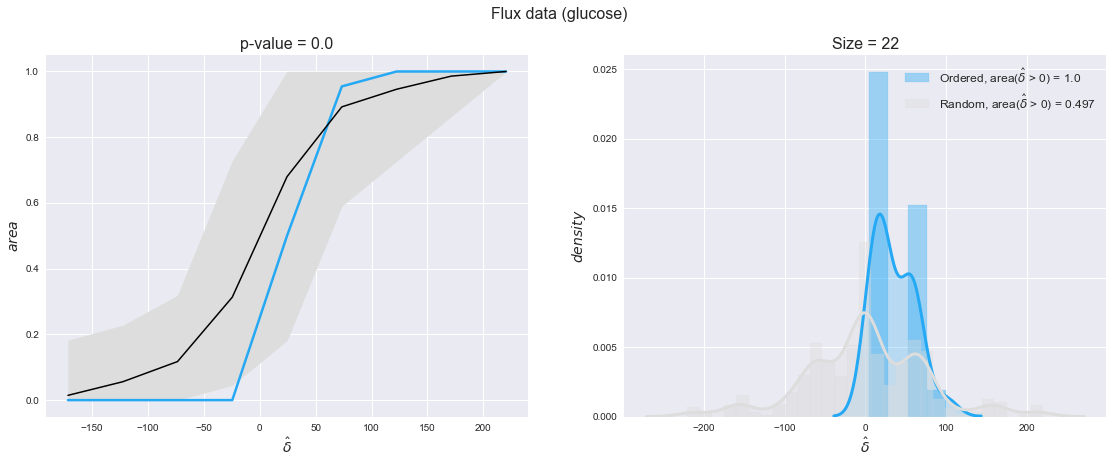

In [75]:
flux_plot_Glu = DataOrderEvaluator(FluxDataNetwork_Orders).evaluateDataOrderRelations(
    data=fluxValues, color='#25a9f4')[0]

Most of the ordered pairs from the little network are not in iJO1366! Yet, I get positve average differences in both cases... Is this real or an artifact... If not artifact, then it is actually a very good result. It implies that flux data satisfies the order relations coming from the network used to estimate it. But, also, satisfies flux orders that come from the entire cellular metabolism too, as demonstrated by the iJO1366 network. This is very impressive since flux order relations in K-12 metabolism were implied in the 13-c data and "survived" the mapping to the little network.

In [122]:
transcript_plots['glucose']

In [123]:
protein_plots['glucose']

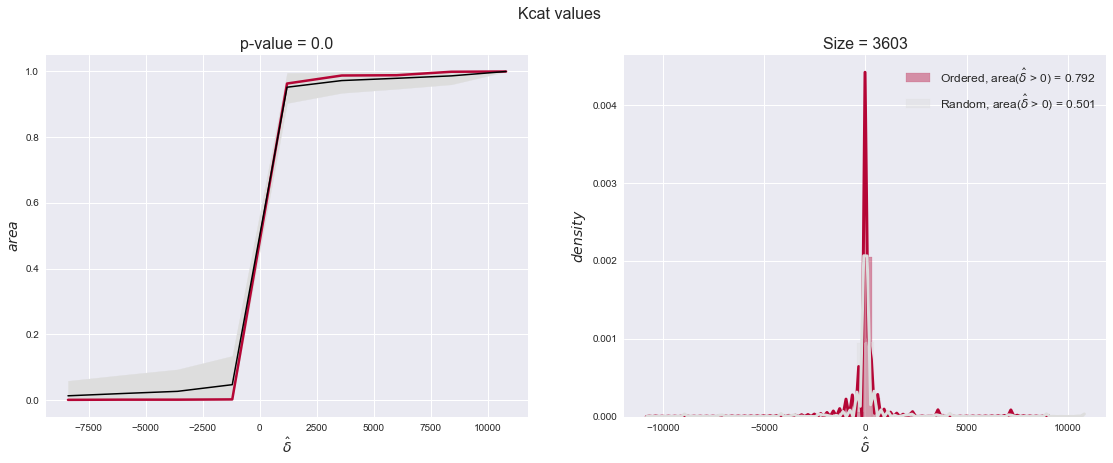

In [77]:
kcat_plot_Glu

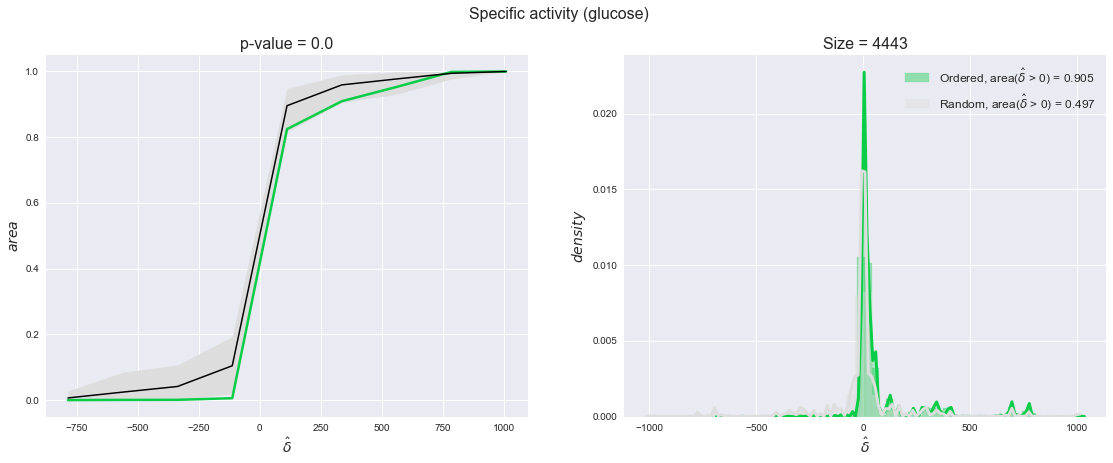

In [78]:
activity_plot_Glu

## Evaluating G scores and nunmber of regulatory interactions per graph level

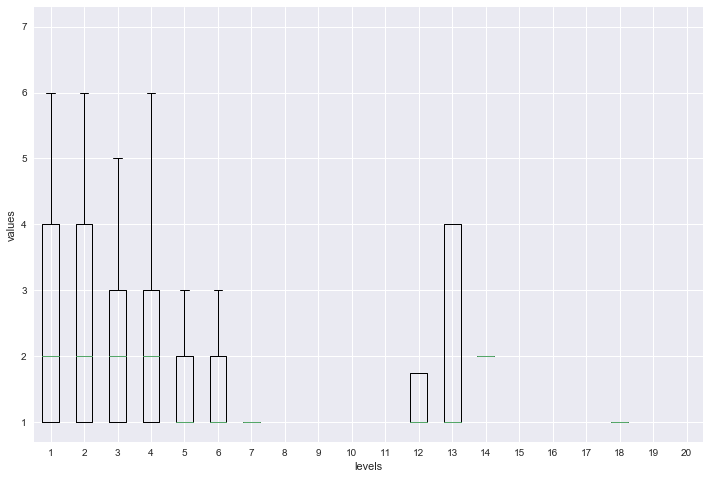

C:\Users\tinta\Anaconda3\lib\site-packages\scipy\stats\stats.py:4911 RuntimeWarning: divide by zero encountered in double_scalars


In [83]:
GraphDataEvaluator = DataOrderEvaluator(iJO1366_Orders, iJO1366['glucose'])
evalRegulations = GraphDataEvaluator.evaluateGeneDataPerGraphLevel(Graph_Levels['glucose'], GRN, statistic='mean')

In [84]:
evalRegulations

{'statistic': [2.257309941520468,
  2.4731182795698925,
  2.268965517241379,
  2.1645569620253164,
  1.6990291262135921,
  1.8709677419354838,
  1.0,
  1.75,
  2.25,
  2.0,
  1.0],
 'pvalues': [[(0, 4), 9e-05],
  [(1, 3), 0.00718],
  [(1, 4), 0.0],
  [(1, 5), 0.02675],
  [(2, 4), 1e-05],
  [(2, 5), 0.04357],
  [(3, 4), 0.00017]]}